In [1]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import rasterio
import pickle
import numpy as np
import random

In [2]:
def calc_dice(labels, preds):
    labels_flat = labels.flatten()
    preds_flat = preds.flatten()
    
    labels_flat = labels_flat.astype(bool).astype(int)
    preds_flat = preds_flat.astype(bool).astype(int)
    
    intersection = np.sum(labels_flat * preds_flat)
    union = np.sum(labels_flat) + np.sum(preds_flat)
    
    if union == 0:
        return 1.0 # sem labels em ambos, ou seja, predição perfeita
    else:
        return (2. * intersection) / union

In [3]:
def read_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

In [4]:

trains = [{'channels': 8, 'layers': 8},
          {'channels': 8, 'layers': 32},
          {'channels': 8, 'layers': 64}
        ]

paths = {
  'T1': 'data/dataset/t1',
  'T2': 'data/dataset/t2',
  'mask': 'data/dataset/mask'
}

root_folder = os.getcwd()

split_paths = 'split_ids.csv'
split_df = pd.read_csv(split_paths)
val_ids = split_df[split_df['split'] == 'val']['ID'].tolist()

In [5]:
def read_mask(path):
    with rasterio.open(path) as src:
        mask = src.read(1).astype(np.float32)
        mask = np.nan_to_num(mask, nan=0.0)
        mask = np.where(mask > 0, 1.0, 0.0)
    return mask

In [6]:
dices = {}

for train in trains:
    channels = train['channels']
    layers = train['layers']
    
    train_name = f'FCN_2D_{channels}ch_{layers}lyr'
    file_path = os.path.join(root_folder, 'results', train_name, 'infer')


    all_labels = []
    all_preds = []
    
    dices[f'{layers}_layers'] =  {}
    dices[f'numero_mask'] =  {}

    for r in val_ids:
        mask = read_mask(os.path.join(paths['mask'], f'recorte_{r}.tif'))
        pickle_pred = read_pickle(os.path.join(file_path, f'recorte_{r}.pkl'))
        pred = np.array(pickle_pred).squeeze()
        
        num_mask = np.sum(mask)
        dices[f'numero_mask'][r] = num_mask
        
        pred_binary = (pred >= 0.5).astype(np.float32)
        dice = calc_dice(mask, pred_binary)
        dices[f'{layers}_layers'][r] = dice 
        
        
        # Flatten para usar no ROC
        all_labels.extend(mask.ravel())
        all_preds.extend(pred.ravel())
        

In [7]:
df_dices = pd.DataFrame(dices)
df_dices.index.name = 'recorte'
cols = df_dices.columns.tolist()
cols = ['numero_mask'] + [col for col in cols if col != 'numero_mask']
df_dices = df_dices[cols]
df_dices.to_csv('dices_infer.csv')
df_dices.head()

,numero_mask,8_layers,32_layers,64_layers
recorte,,,,
3,1181.0,0.972034,0.960000,0.951834
12,44.0,0.694215,0.661017,0.715596
14,0.0,1.000000,1.000000,1.000000
15,11.0,0.000000,0.166667,0.000000
24,1022.0,0.912593,0.921090,0.903627


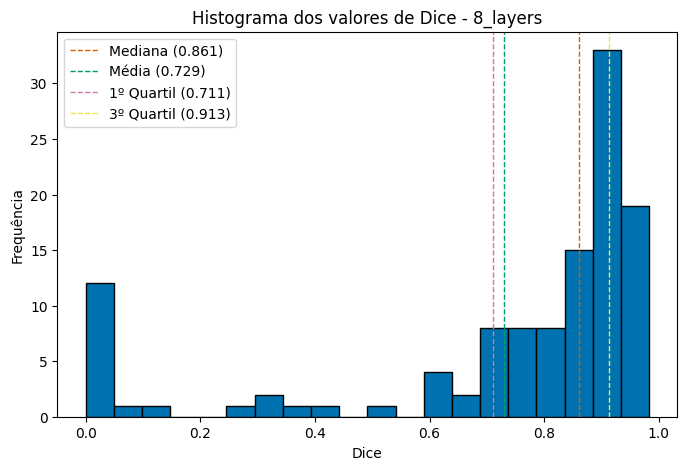

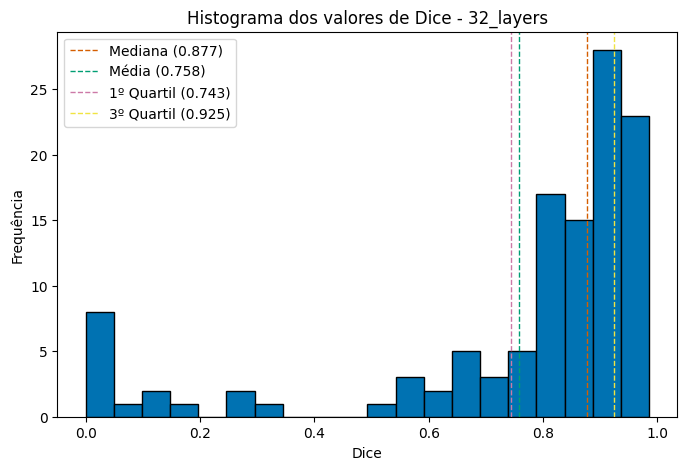

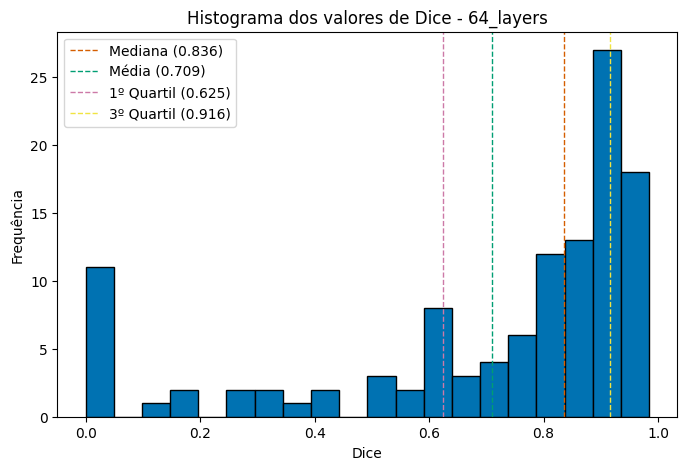

In [8]:
df_dices_with_mask = df_dices[df_dices['numero_mask'] > 0]

for i in df_dices_with_mask.columns:
    if i == 'numero_mask':
        continue
    
    median_dice = df_dices_with_mask[i].median()
    mean_dice = df_dices_with_mask[i].mean()
    first_quartile = df_dices_with_mask[i].quantile(0.25)
    third_quartile = df_dices_with_mask[i].quantile(0.75)
    
    plt.figure(figsize=(8, 5))
    plt.hist(df_dices_with_mask[i], bins=20, edgecolor='black', color='#0072B2')  # blue
    plt.title(f'Histograma dos valores de Dice - {i}')
    plt.xlabel('Dice')
    plt.ylabel('Frequência')
    plt.axvline(median_dice, color='#D55E00', linestyle='dashed', linewidth=1, label=f'Mediana ({median_dice:.3f})')  # vermelha/laranja
    plt.axvline(mean_dice, color='#009E73', linestyle='dashed', linewidth=1, label=f'Média ({mean_dice:.3f})')  # verde
    plt.axvline(first_quartile, color='#CC79A7', linestyle='dashed', linewidth=1, label=f'1º Quartil ({first_quartile:.3f})')  # magenta
    plt.axvline(third_quartile, color='#F0E442', linestyle='dashed', linewidth=1, label=f'3º Quartil ({third_quartile:.3f})')  # amarelo
    
    
    plt.legend()
    plt.show()
    

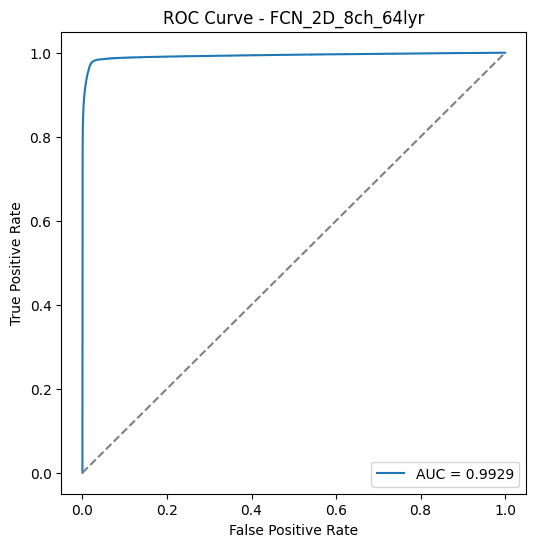

In [9]:
labels = np.array(all_labels)
preds = np.array(all_preds)
auc = roc_auc_score(labels, preds)
fpr, tpr, thresholds = roc_curve(labels, preds)

# print(f"AUC-ROC: {auc:.4f}")

# --- Plotar curva ROC ---
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - {train_name}")
plt.legend()
plt.show()